In [92]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wav
import os

from collections import namedtuple
from scipy.fft import rfft, rfftfreq
from scipy.signal import find_peaks


AUDIO_DIR = "audio/"


# named tuple to representing a signal
Signal = namedtuple("Signal", ["y", "fs", "file"])


# create a signal from a file
def signal_from_file(filename):
    # read the audio file
    fs, y = wav.read(filename)

    # normalize the signal
    # signal values are stored as 16-bit integers
    y = y / 2**15

    return Signal(y, fs, os.path.basename(filename))


# decompose a signal into non overlapping frames
def non_overlapping_frames(signal, frame_duration):
    frame_len = round(frame_duration * signal.fs)
    total_frames = len(signal.y) // frame_len

    frames = signal.y[: total_frames * frame_len]
    frames = frames.reshape(frame_len, total_frames, order="F")

    return frames


# plot signal in continuous time
def plot_signal_continuous(y, fs, title, ylabel=None):
    t = np.arange(len(y)) / fs

    plt.plot(t, y)
    plt.xlabel("Time (s)")
    plt.title(title)

    if ylabel:
        plt.ylabel(ylabel)

    plt.show()


# plot signal in continuous and discrete time
def plot_signal_continuous_and_discrete(
    y, fs, title, continuous_vlines=None, discrete_vlines=None
):
    t = np.arange(len(y)) / fs
    n = np.arange(len(y))

    fig, ax = plt.subplots(2, layout="constrained")

    # plot the signal in continuous time
    ax[0].plot(t, y)
    ax[0].set_xlabel("Time (s)")
    ax[0].set_title("Continuous")

    if continuous_vlines is not None:
        for vline in continuous_vlines:
            ax[0].axvline(vline, color="r", linestyle="--")

    # plot the signal in discrete time
    ax[1].plot(n, y)
    ax[1].set_xlabel("n")
    ax[1].set_title("Discrete")

    if discrete_vlines is not None:
        for vline in discrete_vlines:
            ax[1].axvline(vline, color="r", linestyle="--")

    fig.suptitle(title)
    plt.show()

## Ejercicio 2.1
Representamos la señal en tiempo discreto y continuo.
También representamos la energia de la señal calculada en frames de 20ms sin solape.

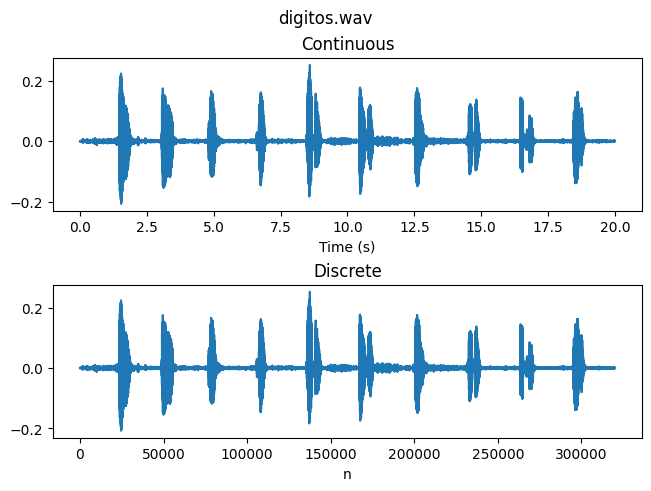

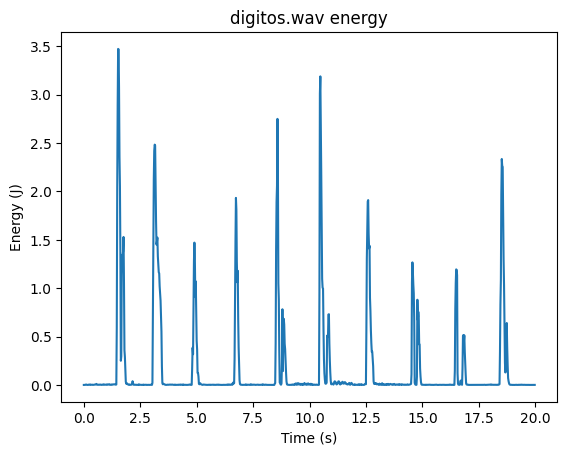

In [93]:
# load the audio file
signal = signal_from_file(os.path.join(AUDIO_DIR, "digitos.wav"))

# represent the signal in continuous and discrete time
plot_signal_continuous_and_discrete(signal.y, signal.fs, signal.file)

frame_duration = 0.02  # frame duration in seconds
frames_fs = 1 / frame_duration  # sampling frequency of the frames

# calculate the energy of the signal in non-overlapping frames
energy_frames = non_overlapping_frames(signal, frame_duration)
signal_energy = (energy_frames**2).sum(axis=0)

# represent the energy of the signal in continuous time
plot_signal_continuous(signal_energy, frames_fs, f"{signal.file} energy", "Energy (J)")

## Ejercicio 2.2
Representamos la señal en tiempo continuo y discreto remarcando los valores escogidos del inicio y del final de cada dígito.

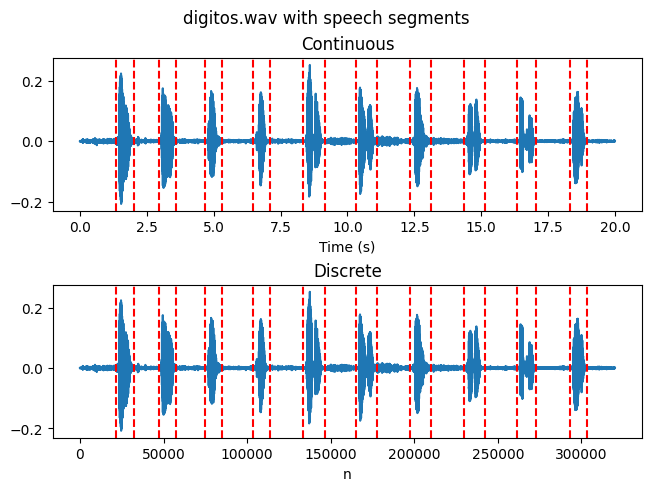

In [94]:
# values hand picked from the plot to represent the speech segments ignoring the silences between them
continuous_speech_segments = np.array(
    [
        (1.34375, 2.03125),
        (2.9375, 3.59375),
        (4.6875, 5.3125),
        (6.46875, 7.09375),
        (8.34375, 9.15625),
        (10.3125, 11.09375),
        (12.34375, 13.125),
        (14.375, 15.125),
        (16.34375, 17.0625),
        (18.3125, 18.9375),
    ]
)

# convert the speech segments to discrete time
discrete_speech_segments = (continuous_speech_segments * signal.fs).astype(int)

# represent the signal in continuous and discrete time with the speech segments highlighted
plot_signal_continuous_and_discrete(
    signal.y,
    signal.fs,
    f"{signal.file} with speech segments",
    continuous_vlines=continuous_speech_segments.flatten(),
    discrete_vlines=discrete_speech_segments.flatten(),
)

## Ejercicio 2.3
Recortamos la señal original, extrayendo cada dígito y guardándolo en un archivo .wav
Añadimos 0.5 segundos de silencio tanto al principio como al final de señal.

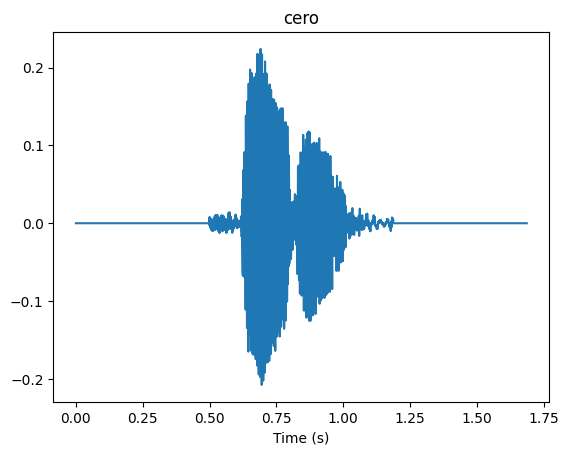

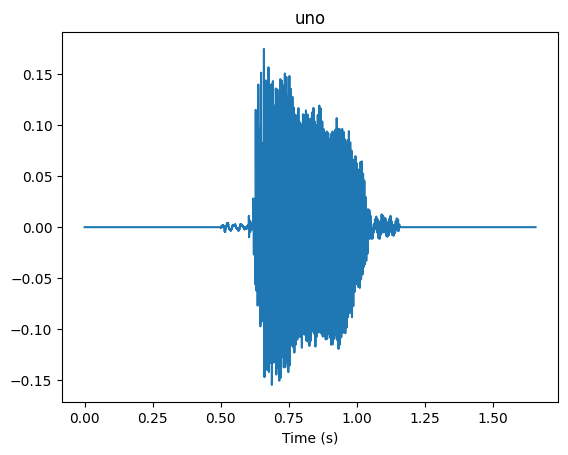

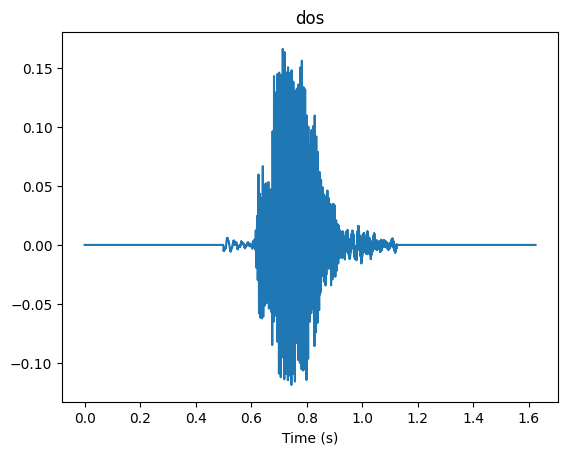

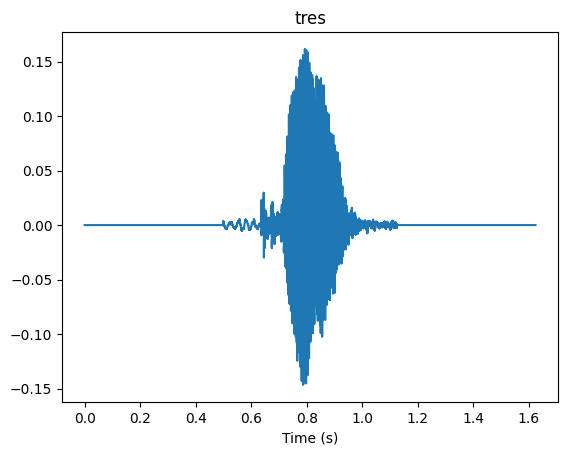

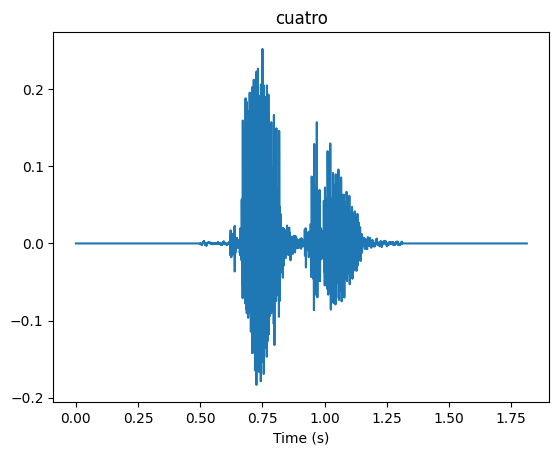

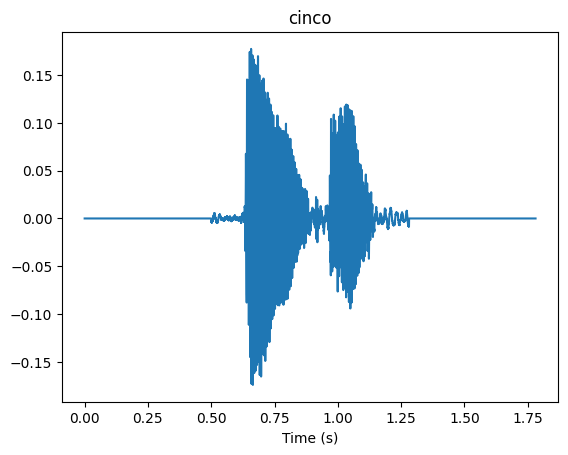

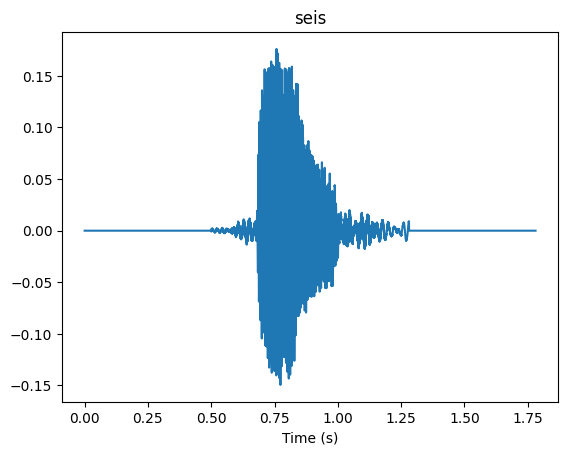

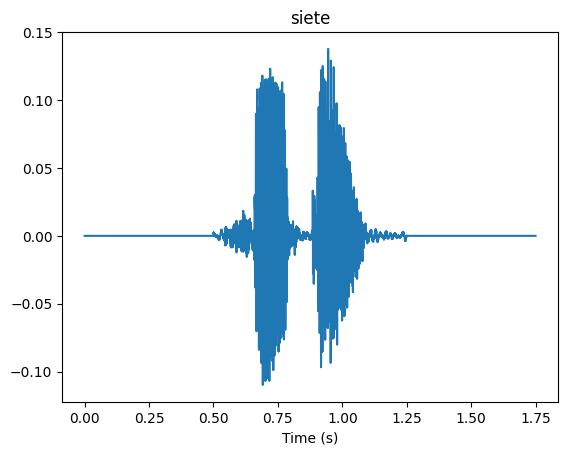

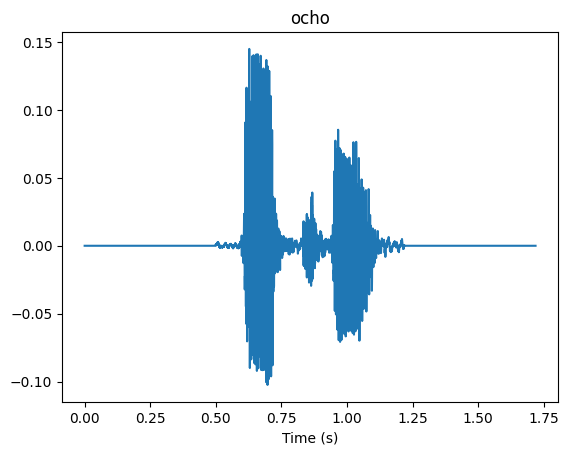

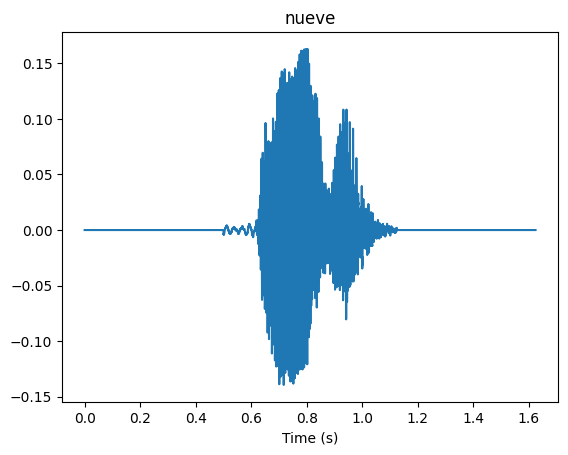

In [95]:
empty_signal_duration = 0.5  # empty signal duration in seconds
empty_signal_len = round(empty_signal_duration * signal.fs)  # empty signal samples
empty_signal = np.zeros(empty_signal_len)

# extract the speech segments from the signal
digit_frames = [
    np.concatenate((empty_signal, signal.y[start:end], empty_signal))
    for start, end in discrete_speech_segments
]

# dictionary with the digit names to use as file names
digits_name_dict = {
    0: "cero",
    1: "uno",
    2: "dos",
    3: "tres",
    4: "cuatro",
    5: "cinco",
    6: "seis",
    7: "siete",
    8: "ocho",
    9: "nueve",
}

for i, digit in enumerate(digit_frames):
    digit_name = digits_name_dict[i]

    # represent the digit in continuous time
    plot_signal_continuous(digit, signal.fs, digit_name)

    # save the digit as a wav file
    digit_path = os.path.join(AUDIO_DIR, digit_name + ".wav")
    # wav.write(digit_path, signal.fs, digit)

## Ejercicio 2.4
Visualizamos 2 frames de 32ms de la señal tres3.wav representando los fonemas 'e' y 's' y su transformada.
Para estimar la frecuencia fundamental en cada frame tomamos los seis primeros 'picos' de la transformada y calculamos la media de la distancia entre ellos.

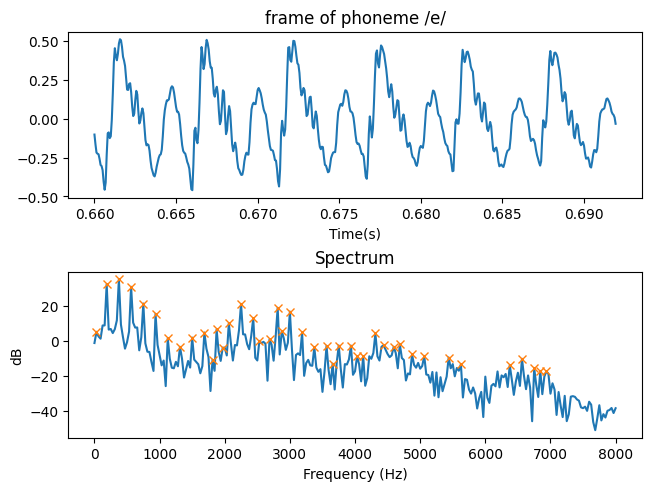

Fundamental frequency estimation of phoneme /e/: 168.4451219512195 Hz


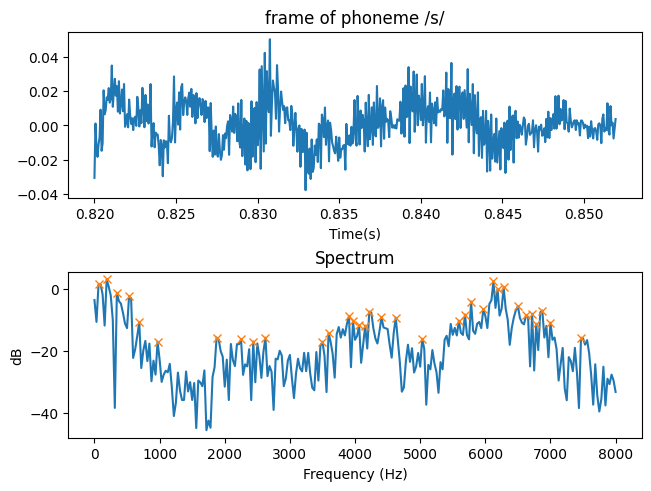

Fundamental frequency estimation of phoneme /s/: 224.4318181818182 Hz


In [96]:
frame_duration = 0.032  # frame duration in seconds

# load the audio file
signal = signal_from_file(os.path.join(AUDIO_DIR, "tres3.wav"))

frame1_start = round(0.66 * signal.fs)  # start of frame 1
frame1_end = frame1_start + round(frame_duration * signal.fs)  # end of frame 1

frame2_start = round(0.82 * signal.fs)  # start of frame 2
frame2_end = frame2_start + round(frame_duration * signal.fs)  # end of frame 2

# get the signal frames with the phonemes that represent
frames = [
    ("e", signal.y[frame1_start:frame1_end], frame1_start, frame1_end),
    ("s", signal.y[frame2_start:frame2_end], frame2_start, frame2_end),
]

for phoneme, frame, frame_start, frame_end in frames:
    # compute the fft of the frame
    frame_fft = abs(rfft(frame))

    # find the peaks
    peaks, _ = find_peaks(frame_fft, distance=5)

    # get the first 6 peaks skipping the first one
    peaks = peaks[1:7]

    # calculate the fundamental frequency as the mean of the differences between the peaks
    peak_frequencies = rfftfreq(len(frame), 1 / signal.fs)[peaks]
    f0 = np.mean(np.diff(peak_frequencies))

    # represent the frame in continuous time and its fft
    fig, ax = plt.subplots(2, layout="constrained")
    t = np.arange(frame_start, frame_end) / signal.fs

    ax[0].plot(t, frame)
    ax[0].set_title(f"frame of phoneme /{phoneme}/")
    ax[0].set_xlabel("Time(s)")

    ts = 1 / signal.fs
    freq = rfftfreq(len(frame), ts)

    ax[1].plot(freq, 20 * np.log10(frame_fft))
    ax[1].plot(freq[peaks], 20 * np.log10(frame_fft[peaks]), "x")
    ax[1].set_title("Spectrum")
    ax[1].set_xlabel("Frequency (Hz)")
    ax[1].set_ylabel("dB")

    plt.show()
    print(f"Fundamental frequency estimation of phoneme /{phoneme}/: {f0} Hz")

## Ejercicio 2.5
Visualizamos el espectro tiempo-frecuencia (T-F).

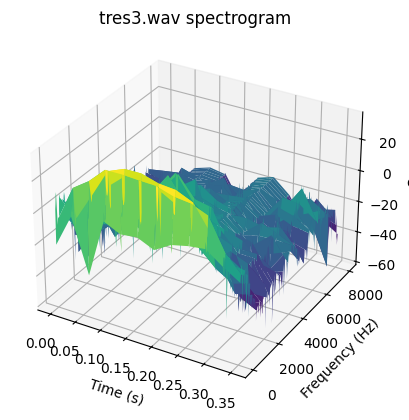

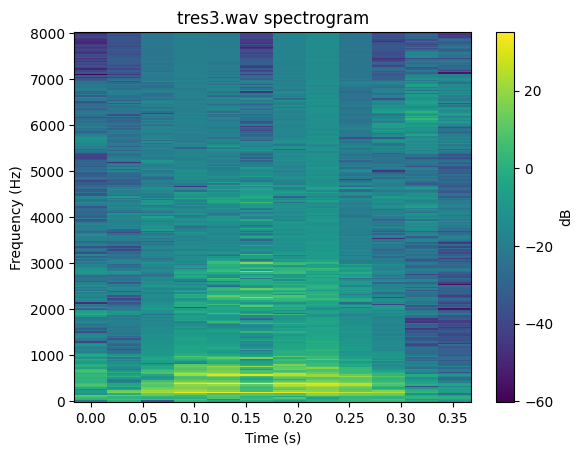

In [97]:
frame_duration = 0.032  # frame duration in seconds

signal_start = round(0.5 * signal.fs)  # start of the signal
signal_end = len(signal.y) - signal_start  # end of the signal

# redefine the signal to only include the speech segment
# named tuple are immutable so we need to create a new one sadly
signal = Signal(signal.y[signal_start:signal_end], signal.fs, signal.file)

# decompose the signal into non overlapping frames
frames = non_overlapping_frames(signal, frame_duration)

# compute the fft of the frames
frames_fft = abs(rfft(frames, axis=0))

# represent the spectrogram of the signal
frame_len, total_frames = frames.shape

t = np.arange(total_frames) * frame_duration
f = rfftfreq(frame_len, 1 / signal.fs)
T, F = np.meshgrid(t, f)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(T, F, 20 * np.log10(frames_fft), cmap="viridis")
ax.set_title(f"{signal.file} spectrogram")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
ax.set_zlabel("dB")
plt.show()

fig, ax = plt.subplots()
pcm = ax.pcolormesh(T, F, 20 * np.log10(frames_fft), cmap="viridis")
fig.colorbar(pcm, ax=ax, label="dB")
ax.set_title(f"{signal.file} spectrogram")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
plt.show()